In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="5"
import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_default_tensor_type('torch.cuda.FloatTensor')
import time

# savepath = "./weightTensor/iper023_refine_rest"
# csw = np.load(os.path.join(savepath, "RGB3S1W24_d10_mc0007f20.npy")) # RGB 3, sigma 1, weight 24
sigmas = np.load("Asigma.npy")

In [2]:
res = sigmas.shape[0]
# gtM = torch.from_numpy(csw[...,3]/csw[...,3].max()*2-1).cuda()
gtM = torch.from_numpy(sigmas/sigmas.max()*2-1).cuda()


In [6]:
Rlist = []
finalloss = []
for d in range(9):
    prev_t = time.time()
    R = 2**d
    cp_vec = torch.randn((res, R, 3), requires_grad=True)
    mse = torch.nn.MSELoss()
    opt = torch.optim.RMSprop([cp_vec], lr=1e-3)
    for iter in range(3000):
        M = torch.sum(cp_vec[:,:,0].reshape(res,1,1,R) * cp_vec[:,:,1].reshape(1,res,1,R) * cp_vec[:,:,2].reshape(1,1,res,R), dim=-1)

        loss = mse(M, gtM)
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        # if iter%50==0:
    print("iter: ", R, " / loss: ", loss.item(), " / time: ", time.time() - prev_t)

    Rlist.append(R)
    finalloss.append(loss.item())

iter:  1  / loss:  0.021129362285137177  / time:  6.391220808029175
iter:  2  / loss:  0.014669962227344513  / time:  9.340874671936035
iter:  4  / loss:  0.006931114010512829  / time:  15.480051755905151
iter:  8  / loss:  0.003711921162903309  / time:  26.989548683166504
iter:  16  / loss:  0.0019660438410937786  / time:  49.77524781227112
iter:  32  / loss:  0.0016285574529320002  / time:  100.61606431007385
iter:  64  / loss:  0.0012878866400569677  / time:  175.5533618927002
iter:  128  / loss:  0.0012110034003853798  / time:  693.317108631134
iter:  256  / loss:  0.001243121107108891  / time:  1703.2328271865845


In [8]:
cp_vec.shape

torch.Size([256, 256, 3])

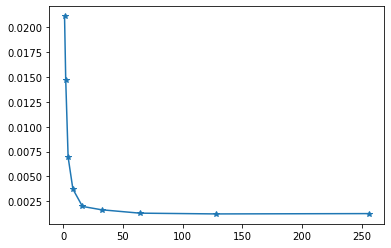

In [7]:
plt.plot(Rlist, finalloss, '*-')

# NN training

In [11]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="6,7"
import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_default_tensor_type('torch.cuda.FloatTensor')

from tqdm import tqdm
import time
import pickle

import torch.nn as nn
import torch.nn.functional as F

def load_pickle_file(pkl_path):
    with open(pkl_path, 'rb') as f:
        data = pickle.load(f, encoding='latin1')
    return data

def load_mixamo_smpl(actions_dir, action_type='0007', skip=1):
    result = load_pickle_file(os.path.join(actions_dir, action_type, 'result.pkl'))

    anim_len = result['anim_len']
    pose_array = result['smpl_array'].reshape(anim_len, -1)
    cam_array = result['cam_array']
    mocap = []
    for i in range(0, anim_len, skip):
        mocap.append({
            'cam': cam_array[i],
            'global_orient': pose_array[i, :3],
            'body_pose': pose_array[i, 3:72],
            'transl': np.array([cam_array[i, 1], cam_array[i, 2], 0])
            })

    return mocap

motionlist = ["{0:04d}".format(i) for i in [22, 31, 32, 70, 83, 102, 145]]
test_motionlist = ["{0:04d}".format(i) for i in [7, 131]]

mocap_dict = {}
for i in motionlist:
    mocap_dict[i] = load_mixamo_smpl('mocap/mixamo/', i, skip=2)

test_mocap_dict = {}
for i in test_motionlist:
    test_mocap_dict[i] = load_mixamo_smpl('mocap/mixamo/', i, skip=2)

# mocap = load_mixamo_smpl('mocap/mixamo/', '0007', skip=2)
R = 48
res = 256

In [2]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        # 아핀(affine) 연산: y = Wx + b
        self.emb_pose = nn.Linear(69, 256)
        self.emb_cpvec = nn.Linear(256*3, 256*3)
        
        self.fc1 = nn.Linear(1024, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 1024)
        self.fc5 = nn.Linear(1024, 256*3)
        
    def forward(self, cp_vec, theta):
        addx = torch.cat((F.relu(self.emb_pose(theta)), F.relu(self.emb_cpvec(cp_vec))), dim=1)
        x = F.relu(self.fc1(addx))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x) + addx)
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x 

In [3]:
cp_vec = torch.from_numpy(np.load("cpvec_sigma.npy")).cuda()


model = Net()
mse = torch.nn.MSELoss()
opt = torch.optim.RMSprop(model.parameters(), lr=1e-3)

sigmas_dict = {}
for i in motionlist:
    sigmas_dict[i] = torch.from_numpy(np.load("sigmas"+i+".npy"))

test_sigmas_dict = {}
for i in test_motionlist:
    test_sigmas_dict[i] = torch.from_numpy(np.load("sigmas"+i+".npy"))

In [30]:
floss = []    
for iter in tqdm(range(3000)):
    loss = 0
    for k in range(10):
        motion_i = np.random.randint(low=0, high=len(mocap_dict), size=1)[0]
        motion = motionlist[motion_i]
        mocap_i = torch.randint(low=0,high=len(mocap_dict[motion]),size=[1])[0]
        poseM = sigmas_dict[motion][mocap_i].float().cuda() # (256, 256, 256)
        body_pose = torch.from_numpy(mocap_dict[motion][mocap_i]['body_pose'][:69]).float().unsqueeze(0).cuda()
        
        new_cpvec = torch.transpose(cp_vec, 0, 1).reshape(-1, 256*3)
        new_theta = torch.repeat_interleave(body_pose, repeats=R, dim=0)
        tf_cpvec = model(new_cpvec, new_theta).reshape(R, 256, 3)
        
        # for initer in range(100):
        tf_M = torch.sum(tf_cpvec[:,:,0].reshape(res,1,1,R) * tf_cpvec[:,:,1].reshape(1,res,1,R) * tf_cpvec[:,:,2].reshape(1,1,res,R), dim=-1)
        loss += mse(tf_M, poseM)
    opt.zero_grad()
    loss.backward()
    opt.step()
    floss.append(loss.item())
    
    if iter % 50 == 0:
        print("iter: ", iter, " / avg loss: ", np.mean(floss), " / std loss: ", np.std(floss))
        floss = []

    if iter % 500 == 0:
        #### validation 
        test_losses = []
        with torch.no_grad():
            for kk in range(10):
                test_motion_i = np.random.randint(low=0, high=len(test_mocap_dict), size=1)[0]
                test_motion = test_motionlist[test_motion_i]

                test_mocap_i = torch.randint(low=0,high=len(test_mocap_dict[test_motion]),size=[1])[0]
                poseM = test_sigmas_dict[test_motion][test_mocap_i].float().cuda() # (256, 256, 256)
                body_pose = torch.from_numpy(test_mocap_dict[test_motion][test_mocap_i]['body_pose'][:69]).float().unsqueeze(0).cuda()
                
                new_cpvec = torch.transpose(cp_vec, 0, 1).reshape(-1, 256*3)
                new_theta = torch.repeat_interleave(body_pose, repeats=R, dim=0)
                tf_cpvec = model(new_cpvec, new_theta).reshape(R, 256, 3)
                
                # for initer in range(100):
                tf_M = torch.sum(tf_cpvec[:,:,0].reshape(res,1,1,R) * tf_cpvec[:,:,1].reshape(1,res,1,R) * tf_cpvec[:,:,2].reshape(1,1,res,R), dim=-1)
                test_losses.append(mse(tf_M, poseM).item())
            
            print("[VAL] avg loss: ", np.mean(test_losses), " / std loss: ", np.std(test_losses))

##### test
with torch.no_grad():
    for test_motion_i in test_motionlist:
        floss = []
        for mocap_i in range(len(test_mocap_dict[test_motion_i])):
            poseM = test_sigmas_dict[test_motion_i][mocap_i].float().cuda() # (256, 256, 256)
            body_pose = torch.from_numpy(test_mocap_dict[test_motion_i][mocap_i]['body_pose'][:69]).float().unsqueeze(0).cuda()

            new_cpvec = torch.transpose(cp_vec, 0, 1).reshape(-1, 256*3)
            new_theta = torch.repeat_interleave(body_pose, repeats=R, dim=0)
            tf_cpvec = model(new_cpvec, new_theta).reshape(R, 256, 3)

            # for initer in range(100):
            tf_M = torch.sum(tf_cpvec[:,:,0].reshape(res,1,1,R) * tf_cpvec[:,:,1].reshape(1,res,1,R) * tf_cpvec[:,:,2].reshape(1,1,res,R), dim=-1)
            floss.append(mse(tf_M, poseM).item())

        print("[TEST] "+test_motion_i+" - #"+str(len(floss))+", avg loss: ", np.mean(floss), ", std loss: ", np.std(floss))

  0%|          | 0/3000 [00:00<?, ?it/s]

iter:  0  / avg loss:  0.2990427017211914  / std loss:  0.0


  0%|          | 1/3000 [00:00<46:54,  1.07it/s]

[VAL] avg loss:  0.035027263406664136  / std loss:  0.027921160696337183


  0%|          | 14/3000 [00:09<32:36,  1.53it/s]


KeyboardInterrupt: 

In [25]:
torch.save(model.state_dict(), "./testmodel.pth")

# COLOR
### rgb rest pose cpvec

In [73]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="7"
import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_default_tensor_type('torch.cuda.FloatTensor')
import time

rgbs = np.load("Argb.npy")
res = rgbs.shape[0]
gtM = torch.from_numpy(rgbs).cuda()

In [74]:
Rlist = []
finalloss = []
# Rlist = [2**d for i in range(9)]
Rlist = [48]
for R in Rlist:
    prev_t = time.time()
    cp_vec = torch.randn((res, R, 3), requires_grad=True)
    B = torch.randn((R, 3), requires_grad=True)
    mse = torch.nn.MSELoss()
    opt = torch.optim.RMSprop([cp_vec], lr=1e-3)
    tmploss = []
    for iter in range(3000+1):
        M = torch.sum(cp_vec[:,:,0].reshape(res,1,1,R,1) * cp_vec[:,:,1].reshape(1,res,1,R,1) * cp_vec[:,:,2].reshape(1,1,res,R,1) * B.reshape(1,1,1,R,3), dim=3)

        loss = mse(M, gtM)
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        if iter%300==0:
            tmploss.append(loss.item())
    print("#R: ", R, " / loss: ", loss.item(), " / time: ", time.time() - prev_t)

    Rlist.append(R)
    finalloss.append(tmploss)

torch.save({"cp_vec":cp_vec, "B":B}, "cpvec_rgb.pth")

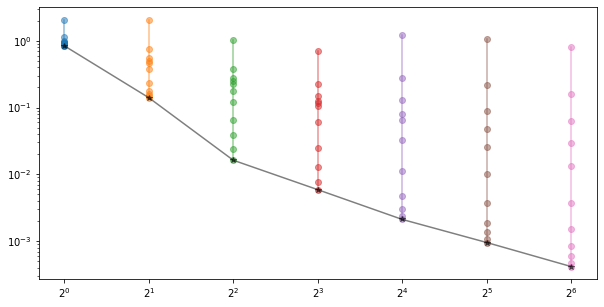

In [71]:
finalloss = np.array(finalloss)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=10)


for i in range(finalloss.shape[0]):
    ax.plot(np.ones(finalloss.shape[1])*Rlist[i], finalloss[i]/Rlist[i], 'o-', alpha=0.5)

ax.plot(np.array(Rlist), finalloss[:,-1]/np.array(Rlist), 'k*-', alpha=0.5)
# ax.xticks(Rlist)
np.save("rgb_finallossR.npy", finalloss)

### rgb mapping model

In [ ]:
motionlist=["0007"]

mocap_dict = {}
for i in motionlist:
    mocap_dict[i] = load_mixamo_smpl('mocap/mixamo/', i, skip=2)

rgbs_dict = {}
for i in motionlist:
    rgbs_dict[i] = torch.from_numpy(np.load("rgbs"+i+".npy"))


loaded = torch.load("cpvec_rgb.pth")
cp_vec = loaded["cp_vec"].cuda()
B = loaded["B"].cuda()

model = Net()
mse = torch.nn.MSELoss()
opt = torch.optim.RMSprop(model.parameters(), lr=1e-3)

floss = []    
for iter in tqdm(range(3000)):
    loss = 0
    for k in range(10):
        motion_i = np.random.randint(low=0, high=len(mocap_dict), size=1)[0]
        motion = motionlist[motion_i]
        mocap_i = torch.randint(low=0,high=len(mocap_dict[motion]),size=[1])[0]
        poseM = rgbs_dict[motion][mocap_i].float().cuda() # (256, 256, 256, 3)
        body_pose = torch.from_numpy(mocap_dict[motion][mocap_i]['body_pose'][:69]).float().unsqueeze(0).cuda()
        
        new_cpvec = torch.transpose(cp_vec, 0, 1).reshape(-1, 256*3)
        new_theta = torch.repeat_interleave(body_pose, repeats=R, dim=0)
        tf_cpvec = model(new_cpvec, new_theta).reshape(R, 256, 3)
        
        # for initer in range(100):
        tf_M = torch.sum(cp_vec[:,:,0].reshape(res,1,1,R,1) * cp_vec[:,:,1].reshape(1,res,1,R,1) * cp_vec[:,:,2].reshape(1,1,res,R,1) * B.reshape(1,1,1,R,3), dim=3)
        loss += mse(tf_M, poseM)
    opt.zero_grad()
    loss.backward()
    opt.step()
    floss.append(loss.item())
    
    if iter % 50 == 0:
        print("iter: ", iter, " / avg loss: ", np.mean(floss), " / std loss: ", np.std(floss))
        floss = []
